In [43]:
using DataFrames
using Gadfly
using Compose
using Cairo
using LsqFit
set_default_plot_size(30cm, 12cm)

In [44]:
# Get ready
home = "/home/german/labo/17/cph_obp/"
cph_outputs = string(home, "run/ctv/data/outputs/")
ctv_cph_outputs = string(home, "run/ctv/data/cph_outputs/")

ph_range = collect(30:5:75)

suffix_pka_file = "_pka"
suffix_pop_file = "_pop"

titrable_cnt = 36
protonated_fraction = Array{Float64, 2}(titrable_cnt, length(ph_range))
deprotonated_fraction = Array{Float64, 2}(titrable_cnt, length(ph_range));

global const def_pka_as4 = 3.71
global const def_pka_gl4 = 4.15
global const def_pka_lys = 10.67
global const def_pka_hip = 6.04;
global const def_pka_cyx = 8.14;
global const def_pka_tyr = 10.1;

### Leyendo de las pop

i = 0
for ph in ph_range
    i+=1
    pop_filename = string(ctv_cph_outputs, ph, suffix_pop_file)
    pop_file = readdlm(pop_filename, header = true)[1][2:end, 2:end]
    if i == 1
        global titrable_resnames = convert(Array{String}, pop_file[:, 1]) # const
        global titrable_resis = convert(Array{Int64}, pop_file[:, 2]) # const
    end

    k = 0
    for resname in titrable_resnames
        k+=1
        if resname == "GL4"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "AS4"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "HIP"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "LYS"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        end
    end            
end

### Leyendo de las pka

In [45]:
i = 0
for ph in ph_range
    i+=1
    pka_filename = string(ctv_cph_outputs, ph, suffix_pka_file)
    pka_file = readdlm(pka_filename, header = true)[1][1:end-1, 1:end-1]
    
    if i == 1
        global titrable_resnames = convert(Array{String}, pka_file[:, 1]); # const
        global titrable_resis = convert(Array{Int64}, pka_file[:, 2]); # const
    end

    protonated_fraction[:, i] = pka_file[:, end-1];
end
deprotonated_fraction = 1 - protonated_fraction;

# Get array with default pkas for each titrable resodie
titrable_def_pka = Array{Float64}(length(titrable_resis))
for i = 1:length(titrable_resis)
    resname = titrable_resnames[i]
    if resname == "GL4"
        titrable_def_pka[i] = def_pka_gl4
    elseif resname == "AS4"
        titrable_def_pka[i] = def_pka_as4
    elseif resname == "HIP"
        titrable_def_pka[i] = def_pka_hip
    elseif resname == "LYS"
        titrable_def_pka[i] = def_pka_lys
    end
end

In [46]:
# Data previo. p[2] será reemplazado por el pka default
titrable_ns = Array{Float64}(length(titrable_resis))
titrable_pkas = Array{Float64}(length(titrable_resis))
titrable_curves = Array{Function}(length(titrable_resis))

model(x, p) = 1 ./ (1 + 10 .^(p[1]*(p[2] - x)) )
xdata = ph_range ./ 10
p = [1.0 ; 6.0]

x = collect(0.0:0.1:14.0);

In [47]:
# Obtengo las titration curves y los pkas
for i = 1:length(titrable_resis)
    if titrable_resnames[i] == "GL4"
        p[2] = def_pka_gl4
    elseif titrable_resnames[i] == "AS4"
        p[2] = def_pka_as4
    elseif titrable_resnames[i] == "HIP"
        p[2] = def_pka_hip
    elseif titrable_resnames[i] == "LYS"
        p[2] = def_pka_lys
    end
    ydata = deprotonated_fraction[i, :];
    fit = curve_fit(model, xdata, ydata, p)
    titrable_ns[i] = fit.param[1]
    titrable_pkas[i] = fit.param[2]
    titrable_curve(x) = 1 ./ (1 + 10 .^ (fit.param[1] .* (fit.param[2] - x)) )
    
    titrable_curves[i] = titrable_curve;
end

# Guardo los pkas obtenidos
df_titrable_ctv = DataFrame(resname = titrable_resnames, resi = titrable_resis, pka = round.(titrable_pkas, 2))
writetable(string(home, "rtdos_log/pka_ctv"), df_titrable_ctv, separator = '\t');

### Diferencias

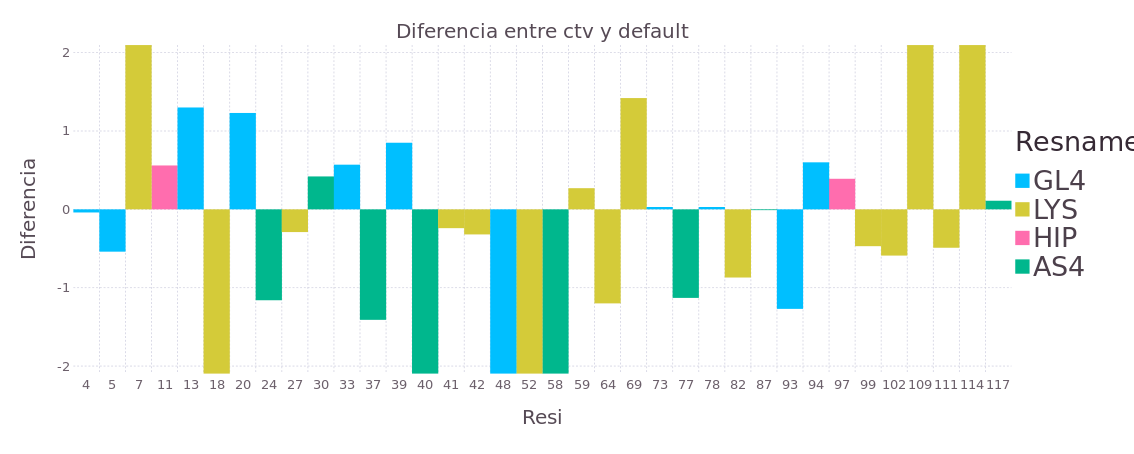

In [48]:
df_dif_ctv_def = DataFrame(Resname = titrable_resnames, Resi = titrable_resis,
    Diferencia = df_titrable_ctv[:pka] - titrable_def_pka)

plot(df_dif_ctv_def, Geom.bar, x = "Resi", y = "Diferencia",  color = "Resname",
    Scale.x_discrete,
    Guide.title("Diferencia entre ctv y default"),
    Coord.cartesian(ymin = -2, ymax = 2),
    Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
        key_title_font_size=20pt, key_label_font_size=20pt))

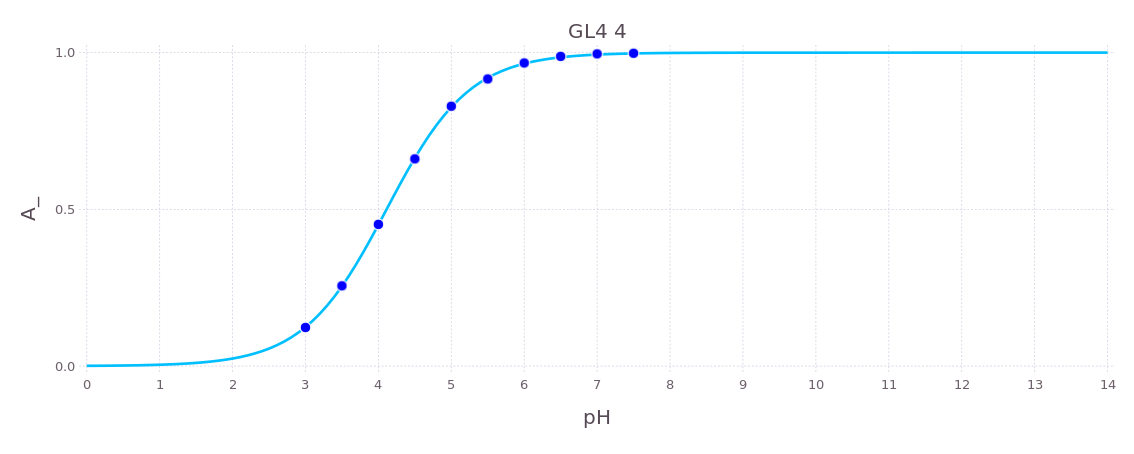

In [49]:
i = 1
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

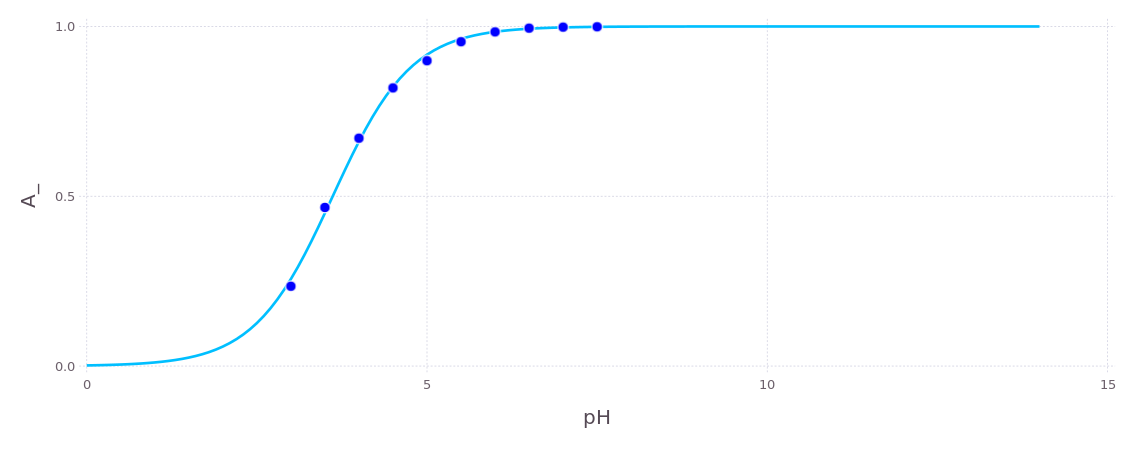

In [50]:
i = 2
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

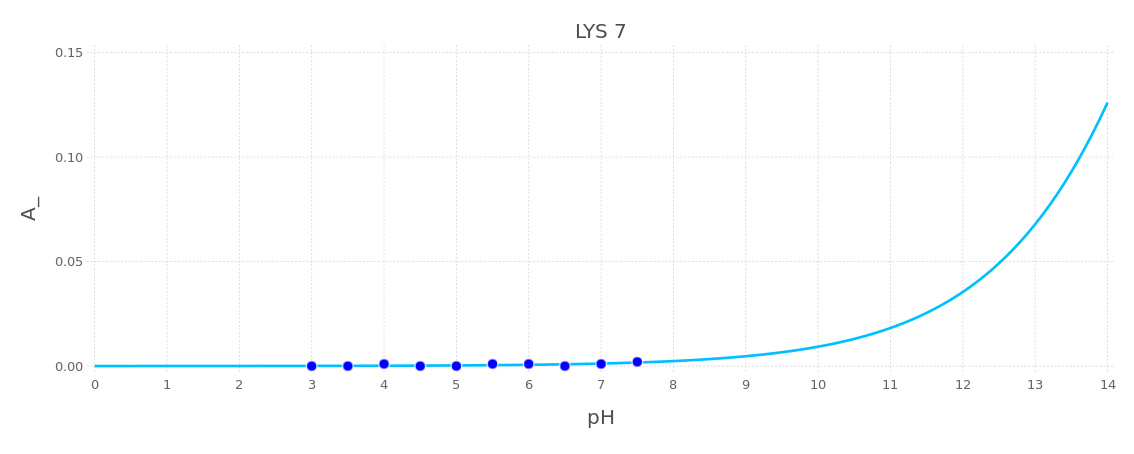

In [51]:
i = 3
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

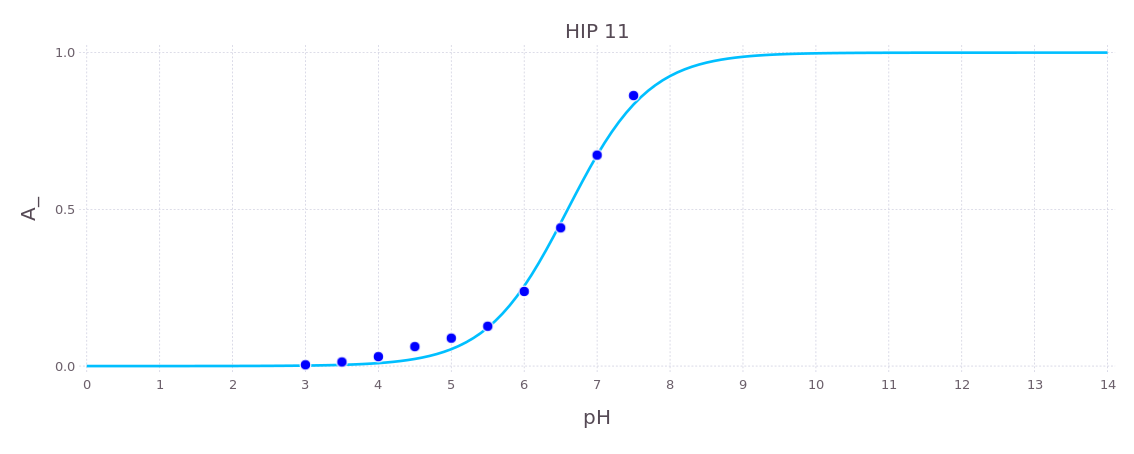

In [52]:
i = 4
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

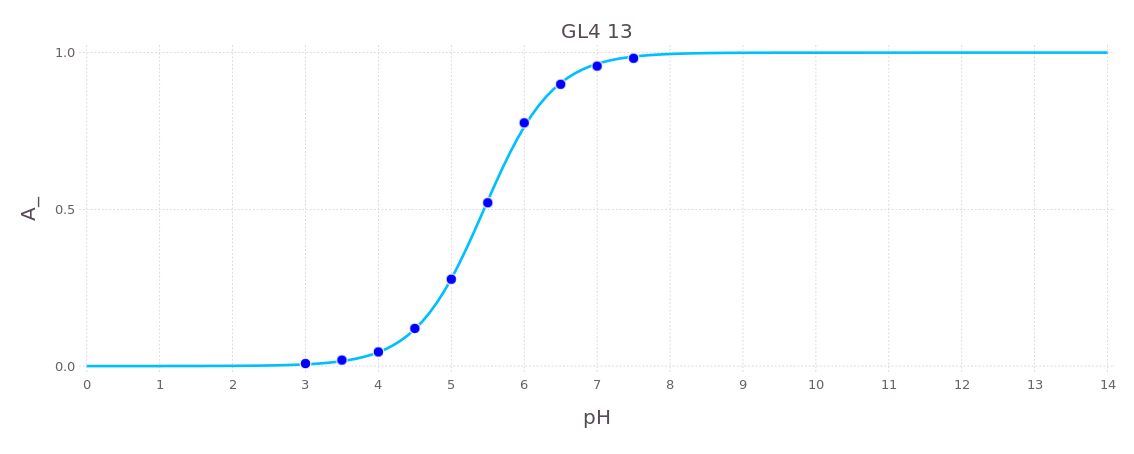

In [53]:
i = 5
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

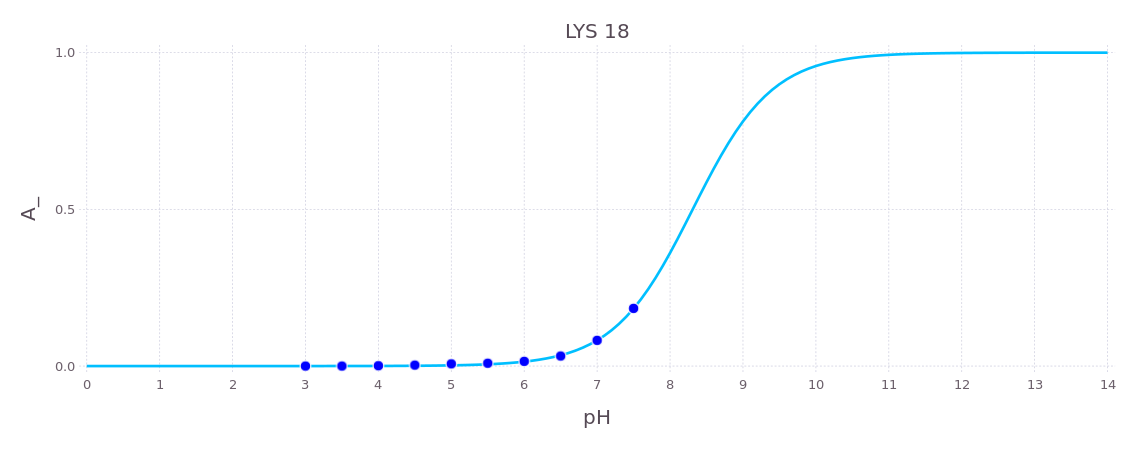

In [54]:
i = 6
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

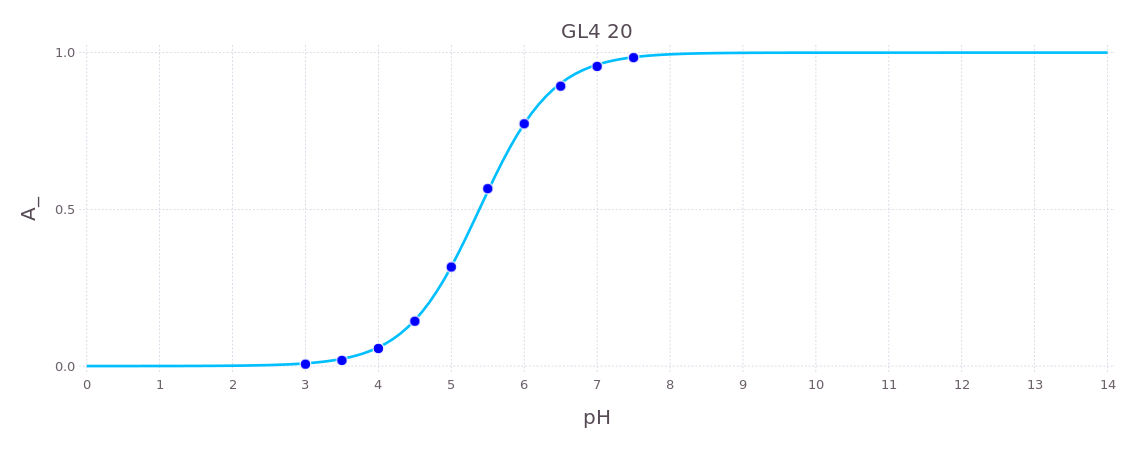

In [55]:
i = 7
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

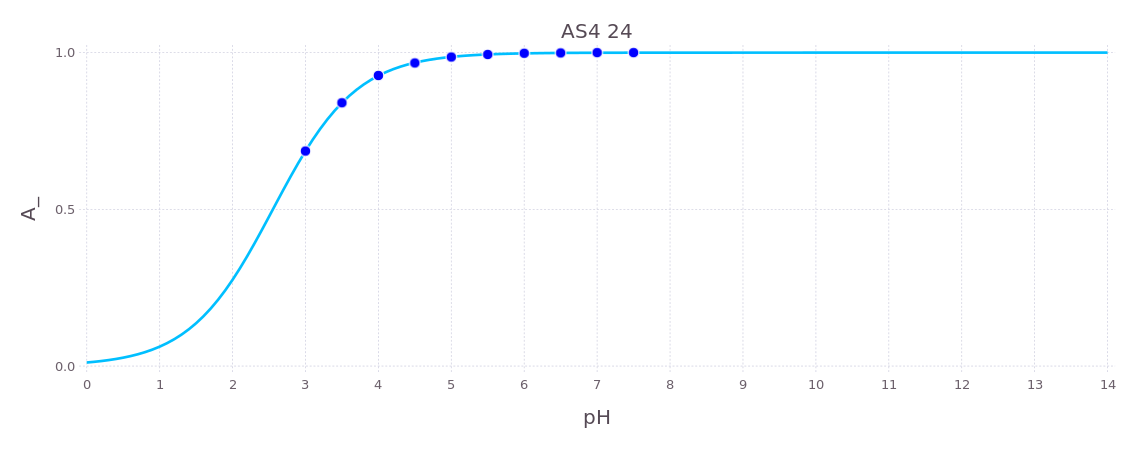

In [56]:
i = 8
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

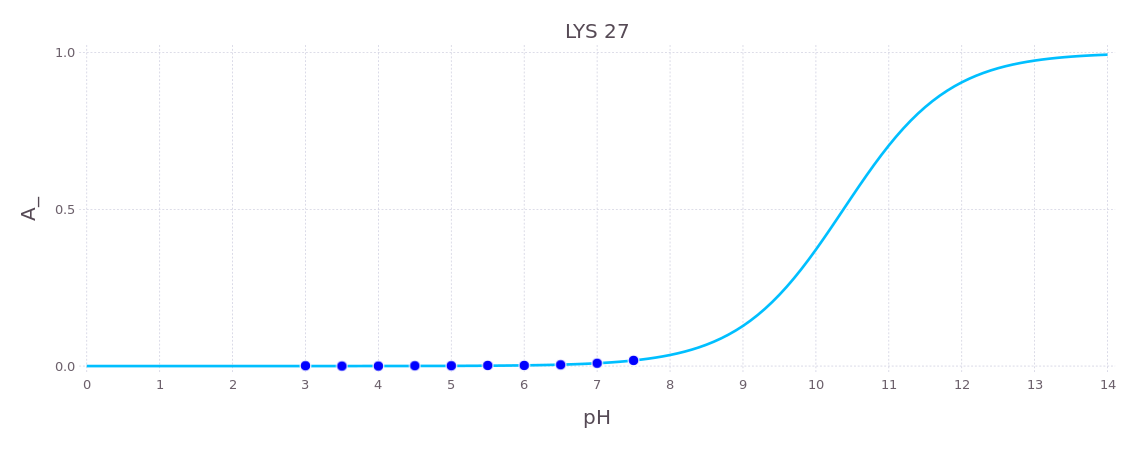

In [57]:
i = 9
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

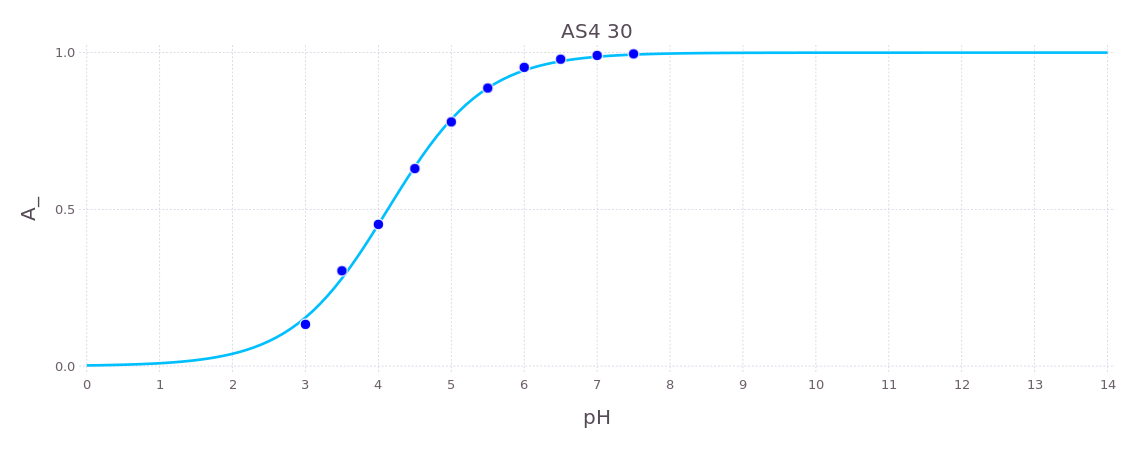

In [58]:
i = 10
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

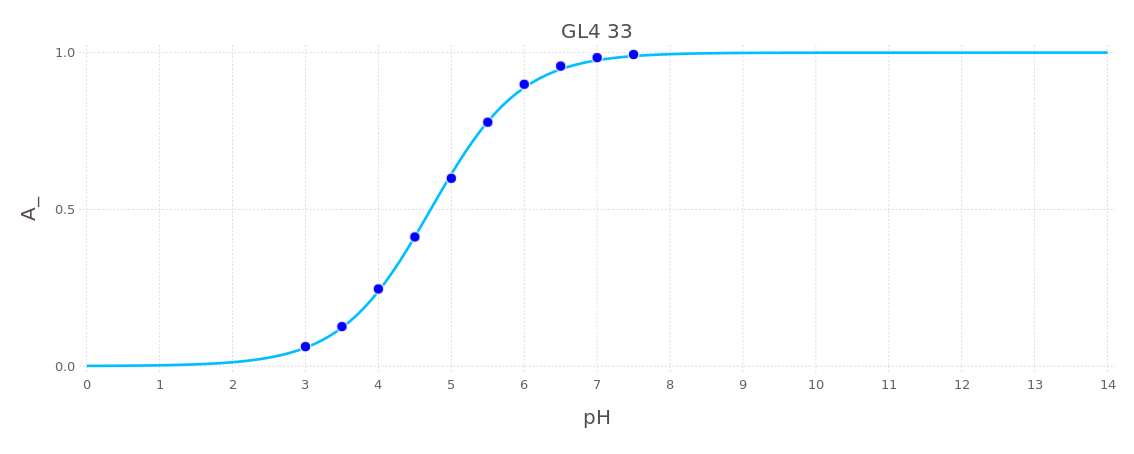

In [59]:
i = 11
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

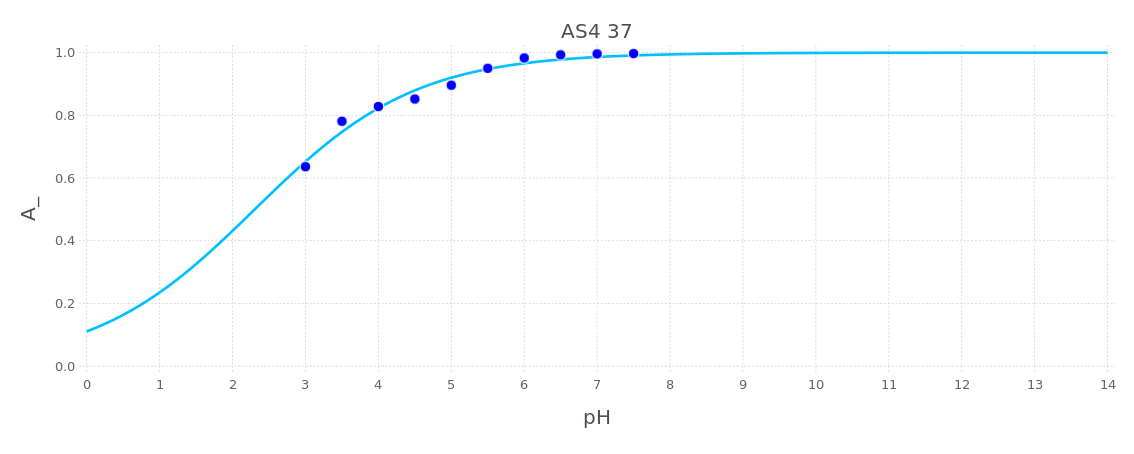

In [60]:
i = 12
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

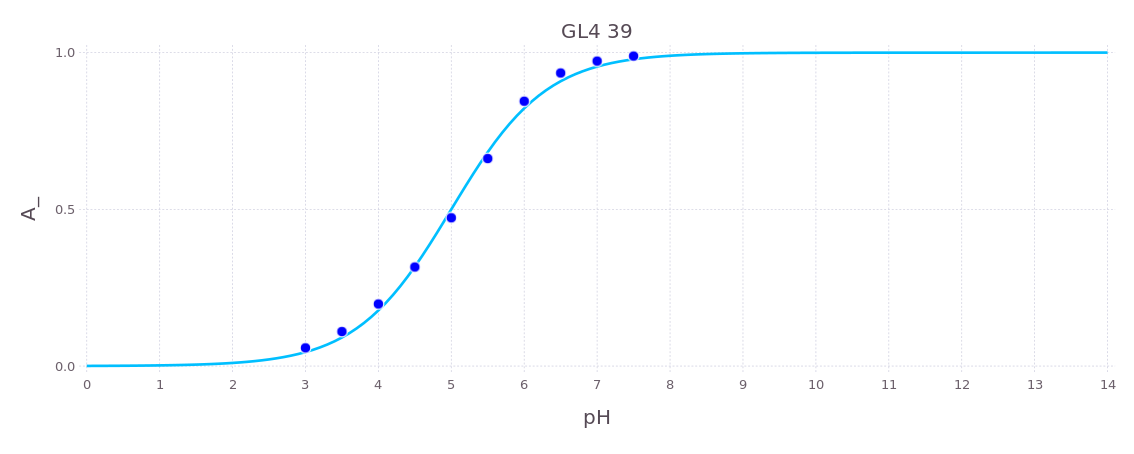

In [61]:
i = 13
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

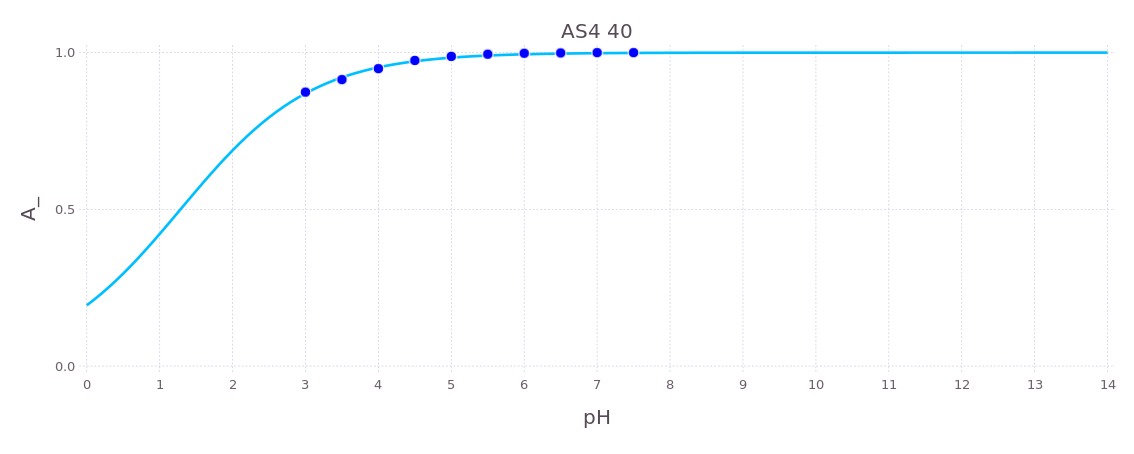

In [62]:
i = 14
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

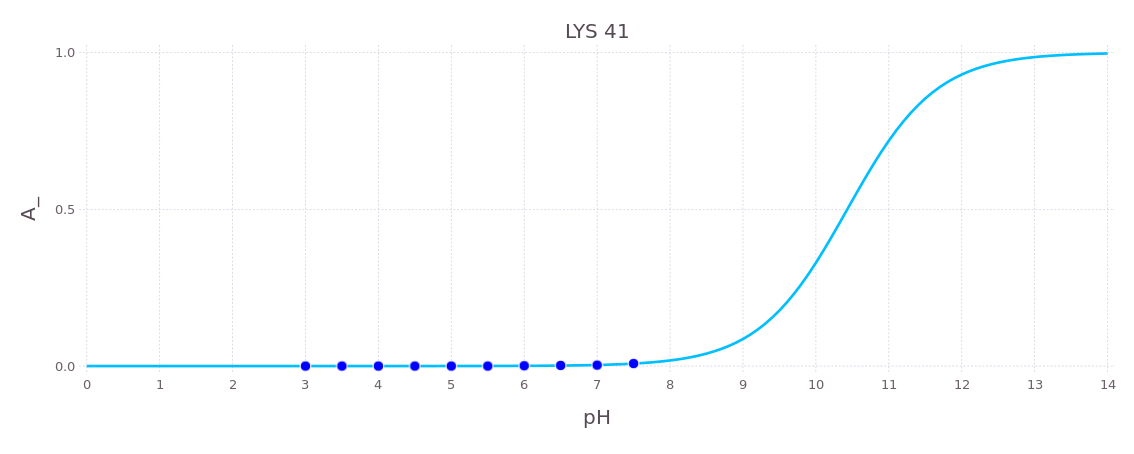

In [63]:
i = 15
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

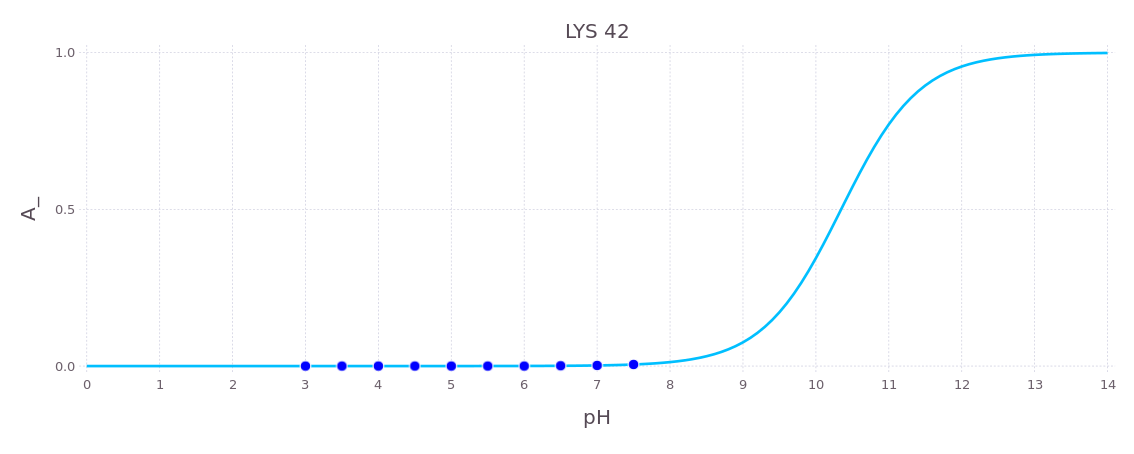

In [64]:
i = 16
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

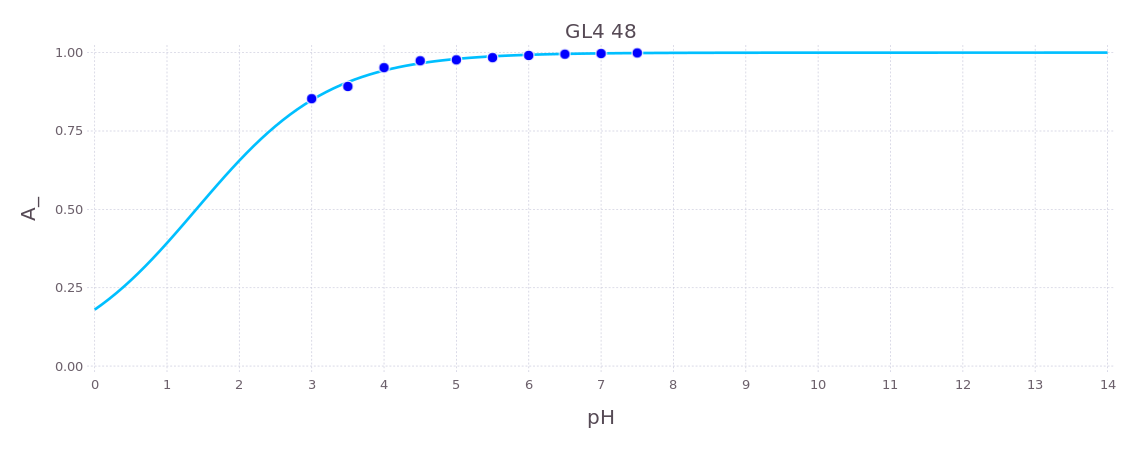

In [65]:
i = 17
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

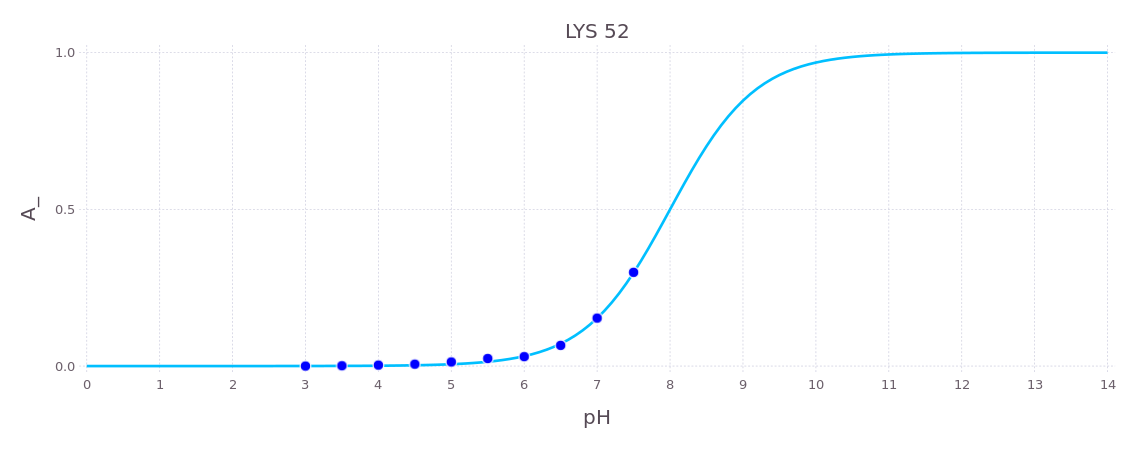

In [66]:
i = 18
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

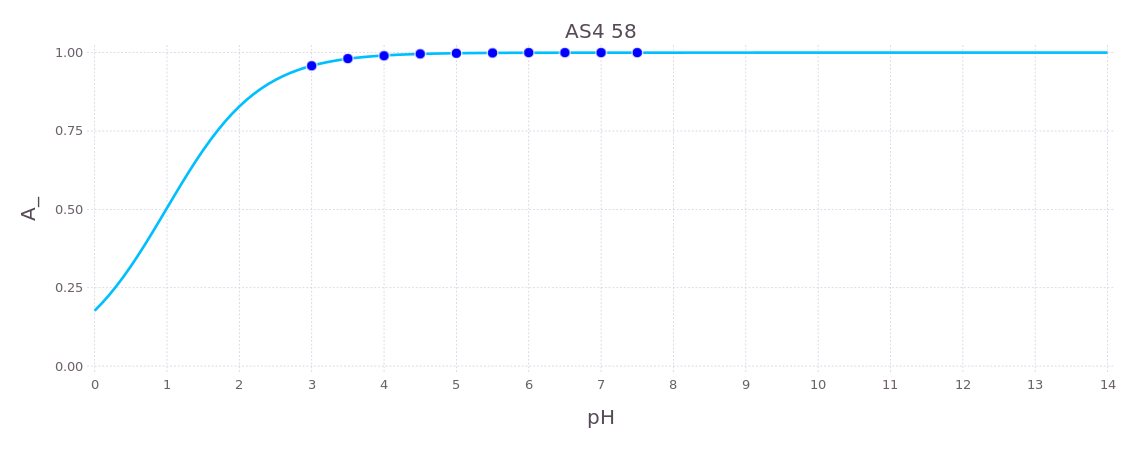

In [67]:
i = 19
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

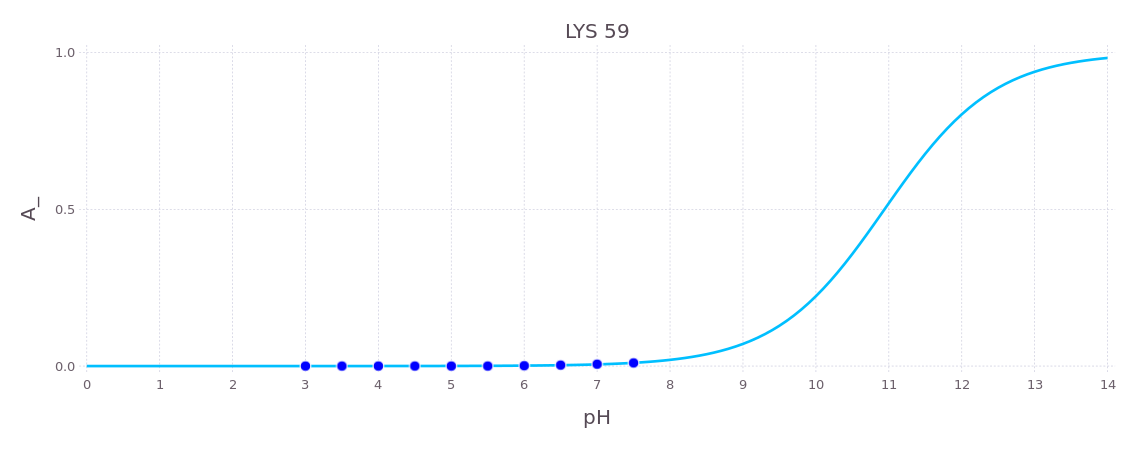

In [68]:
i = 20
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

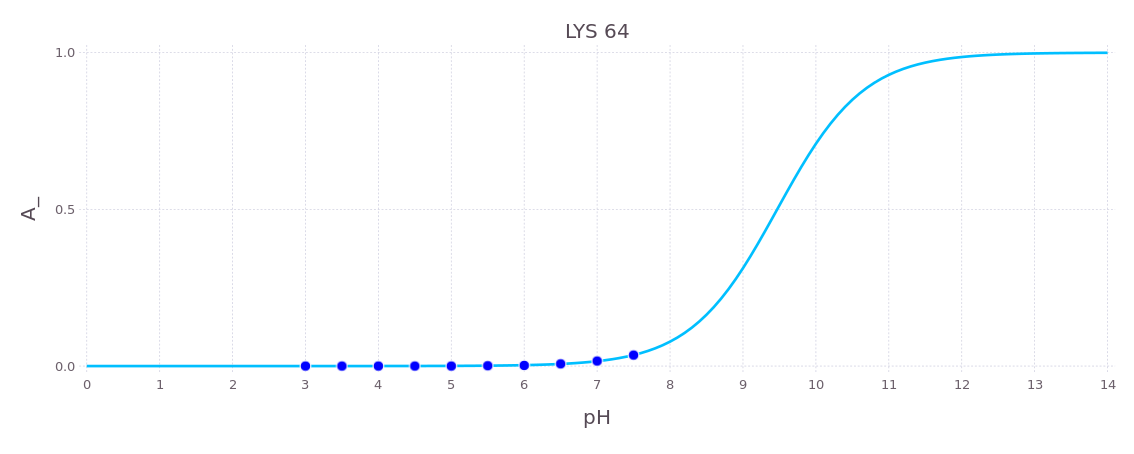

In [69]:
i = 21
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

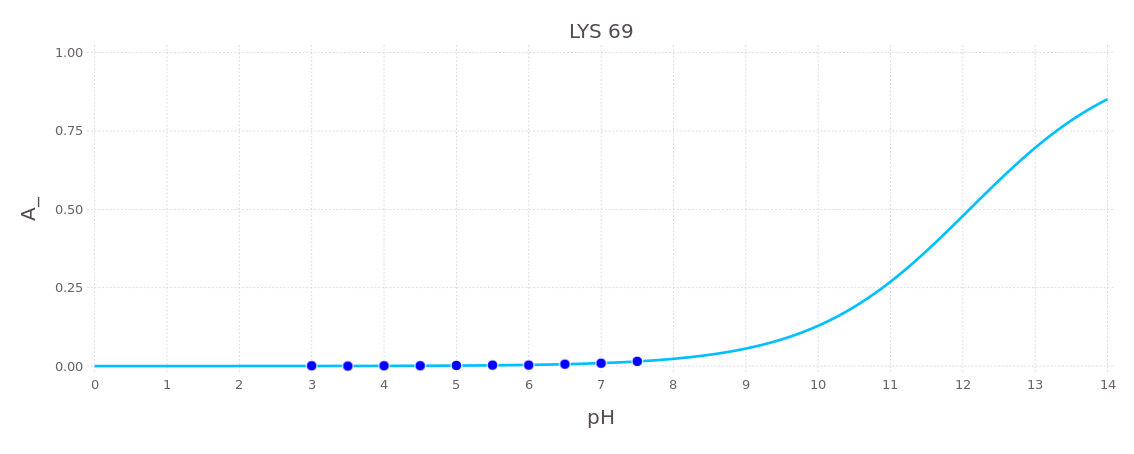

In [70]:
i = 22
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

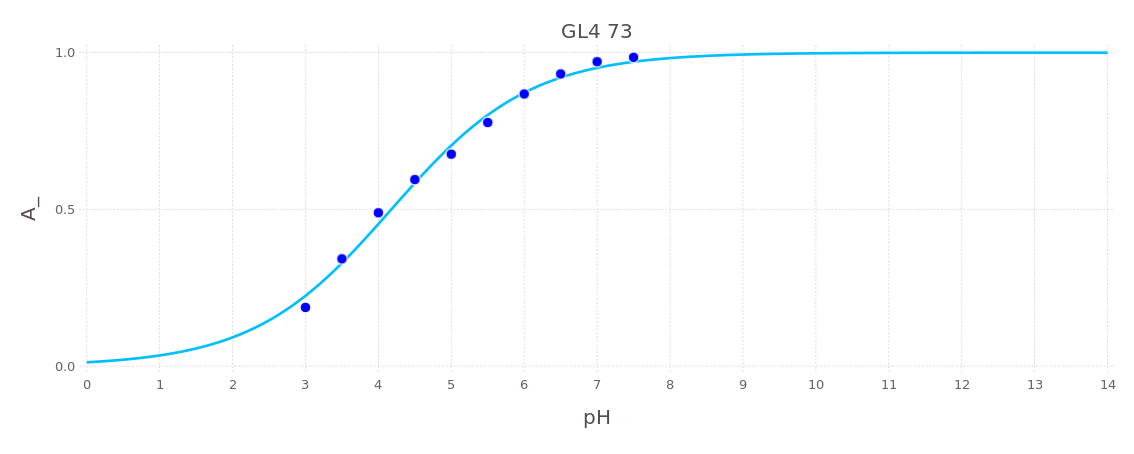

In [71]:
i = 23
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

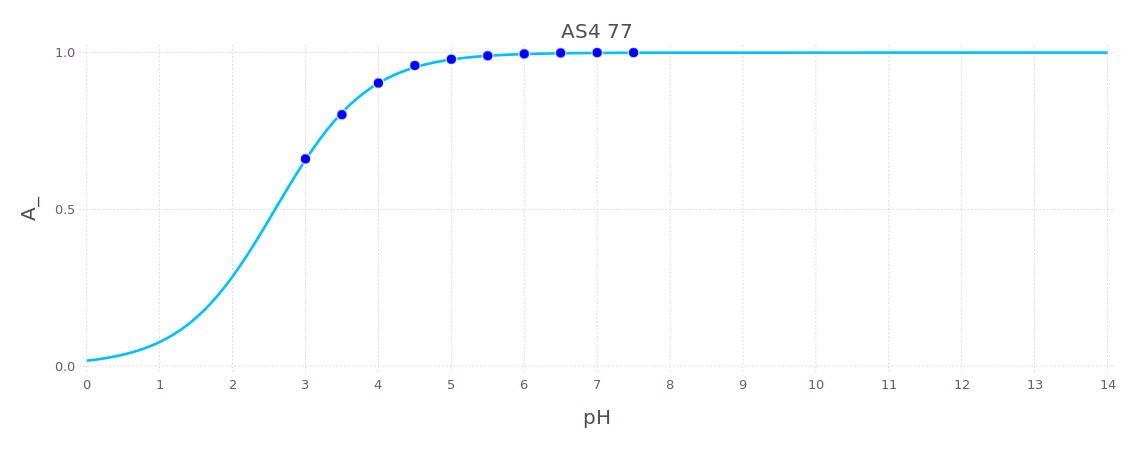

In [72]:
i = 24
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

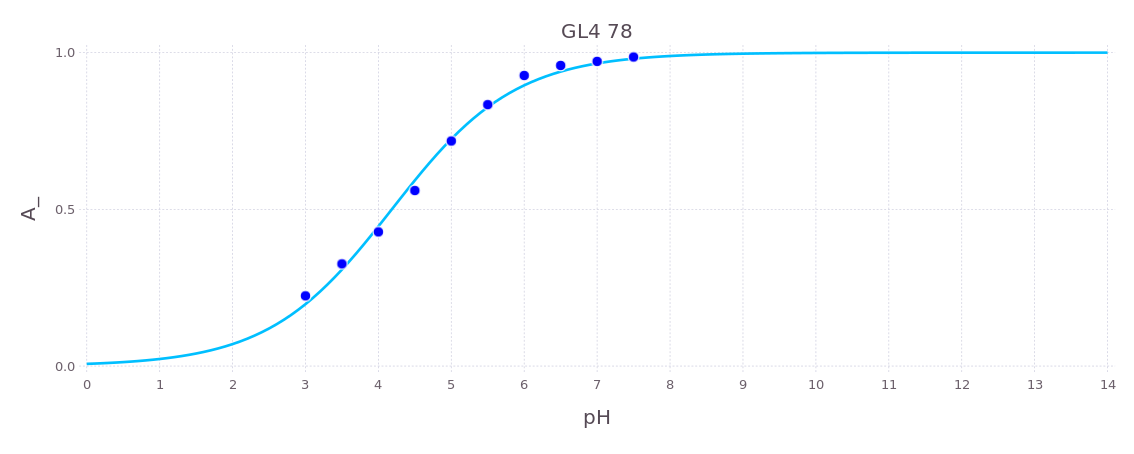

In [73]:
i = 25
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

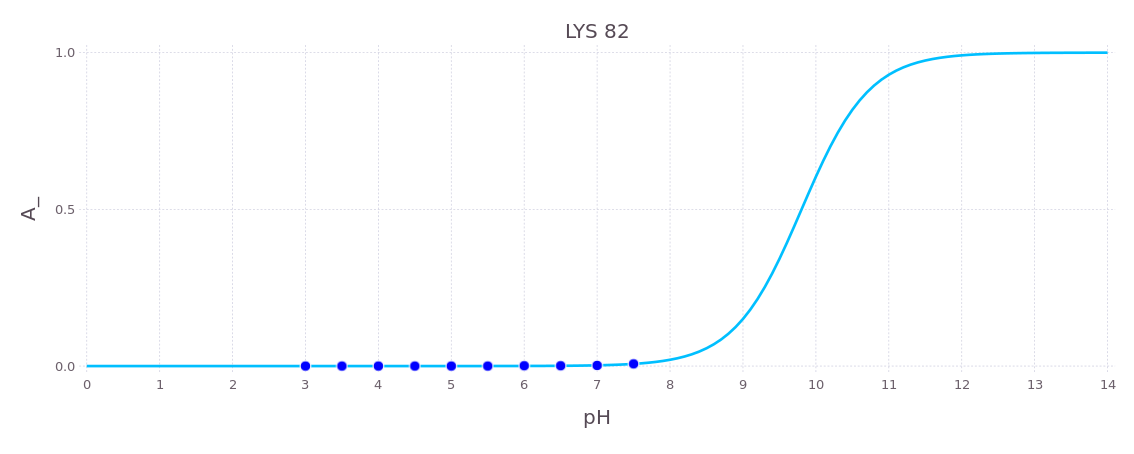

In [74]:
i = 26
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

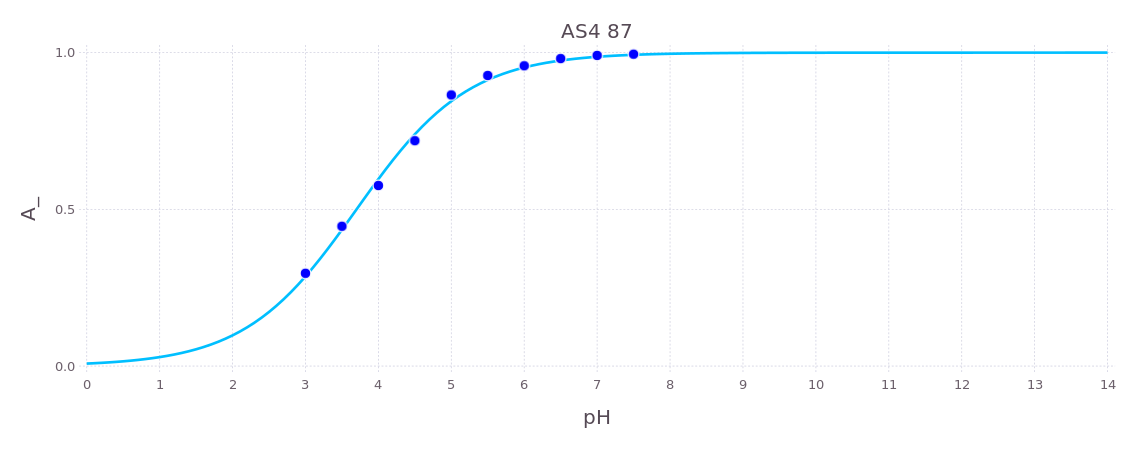

In [75]:
i = 27
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

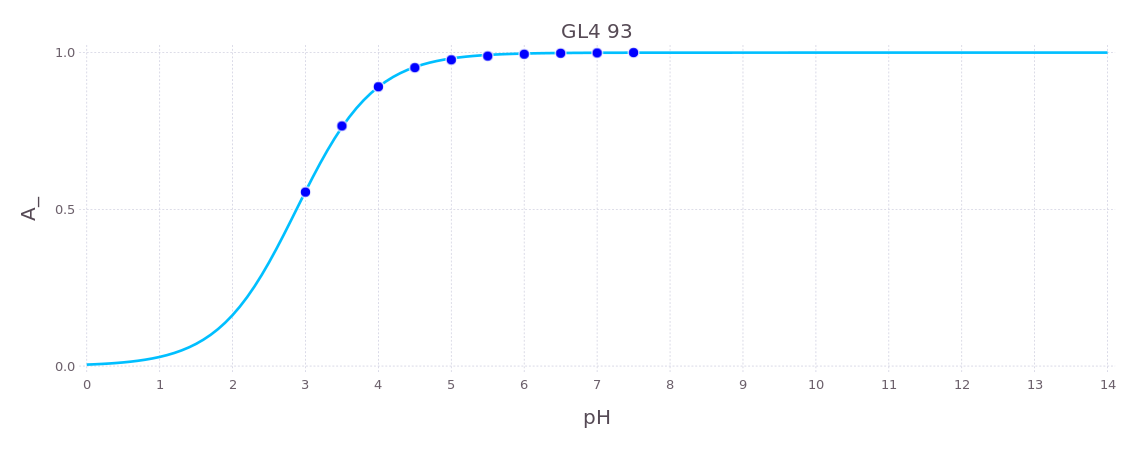

In [76]:
i = 28
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

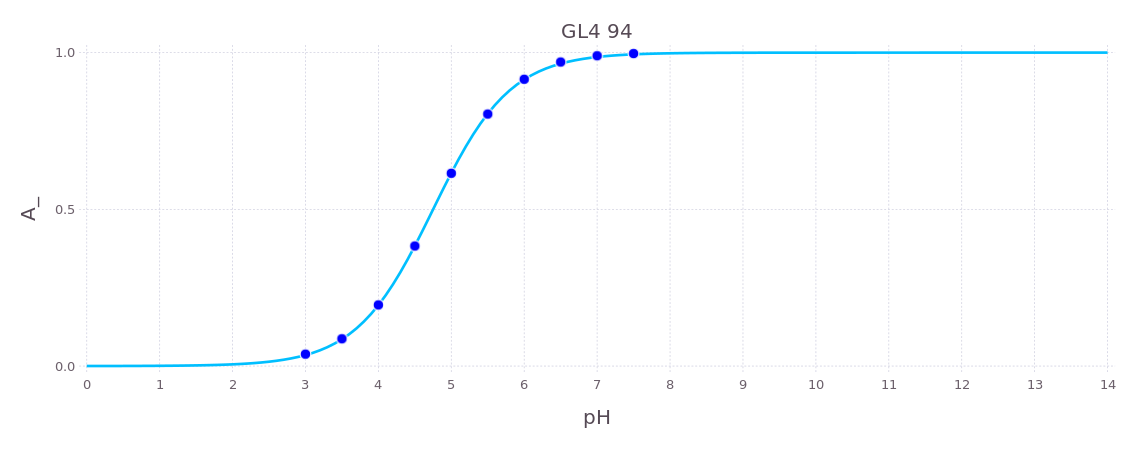

In [77]:
i = 29
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

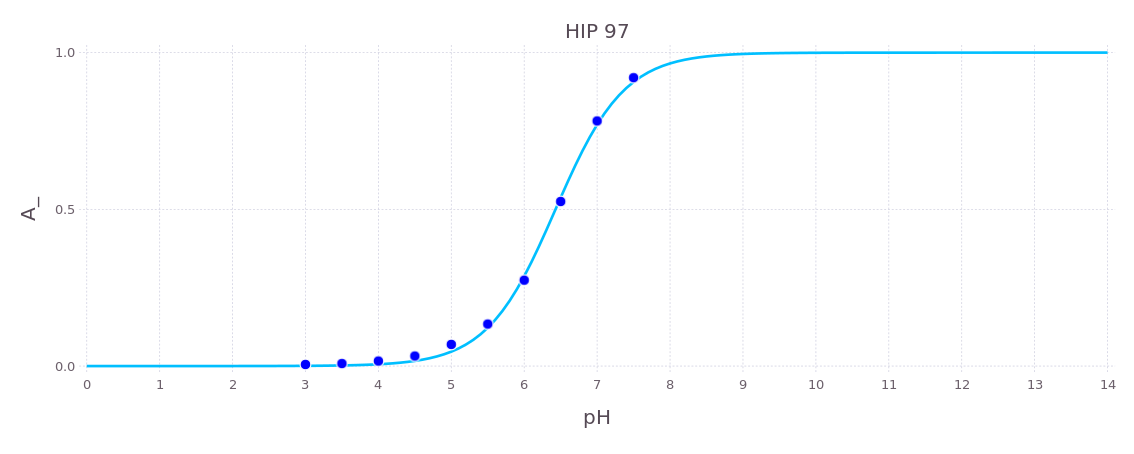

In [78]:
i = 30
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

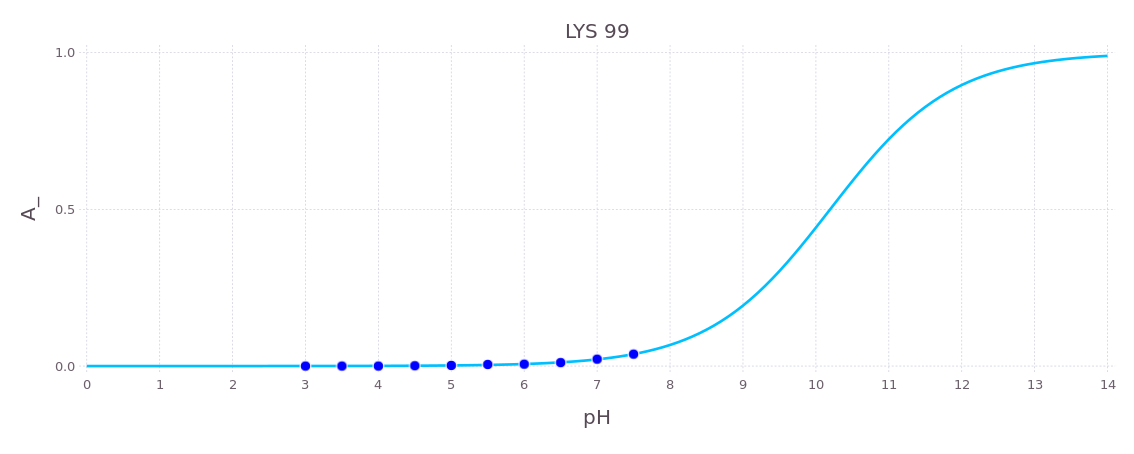

In [79]:
i = 31
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

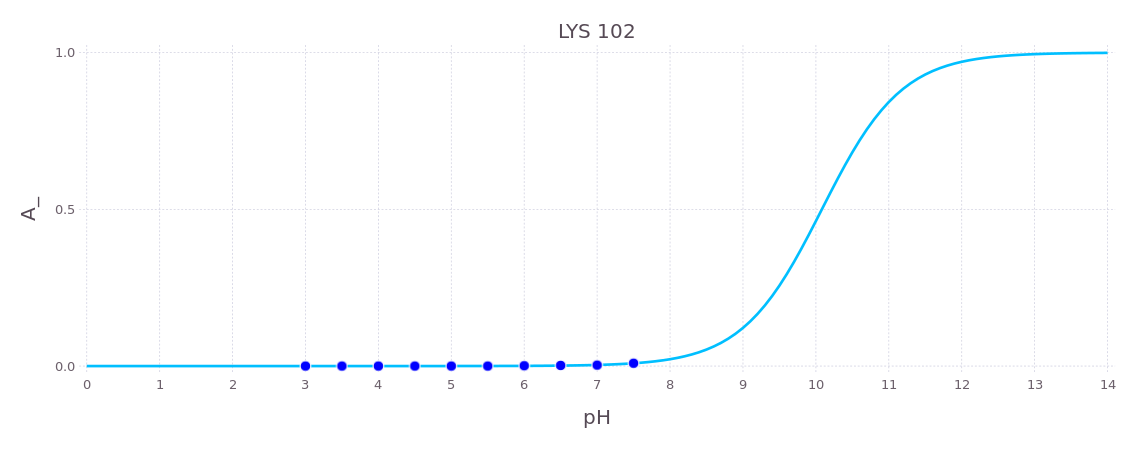

In [80]:
i = 32
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

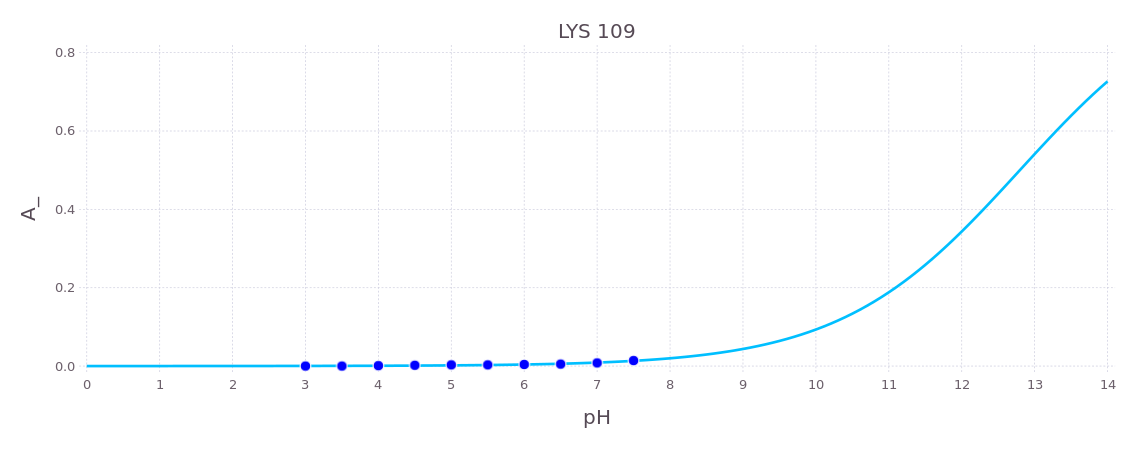

In [81]:
i = 33
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

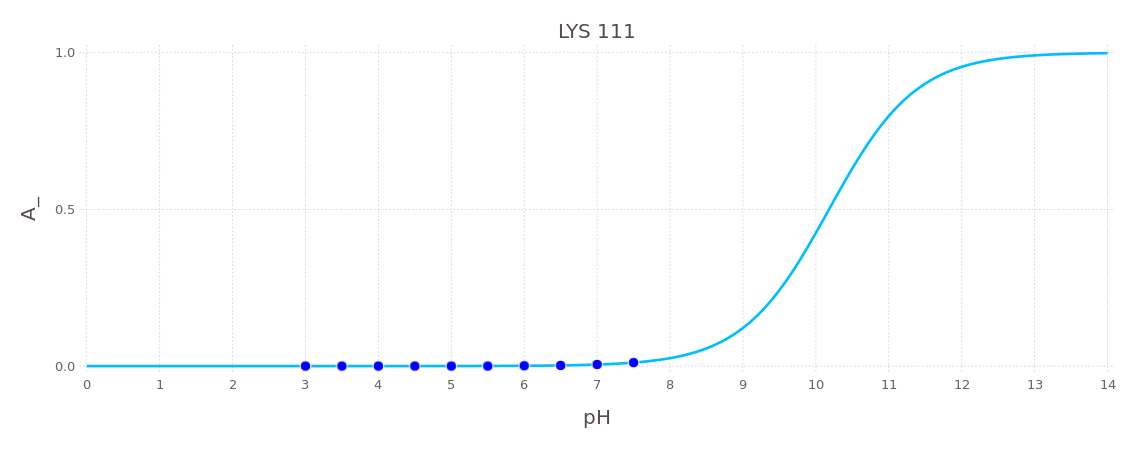

In [82]:
i = 34
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

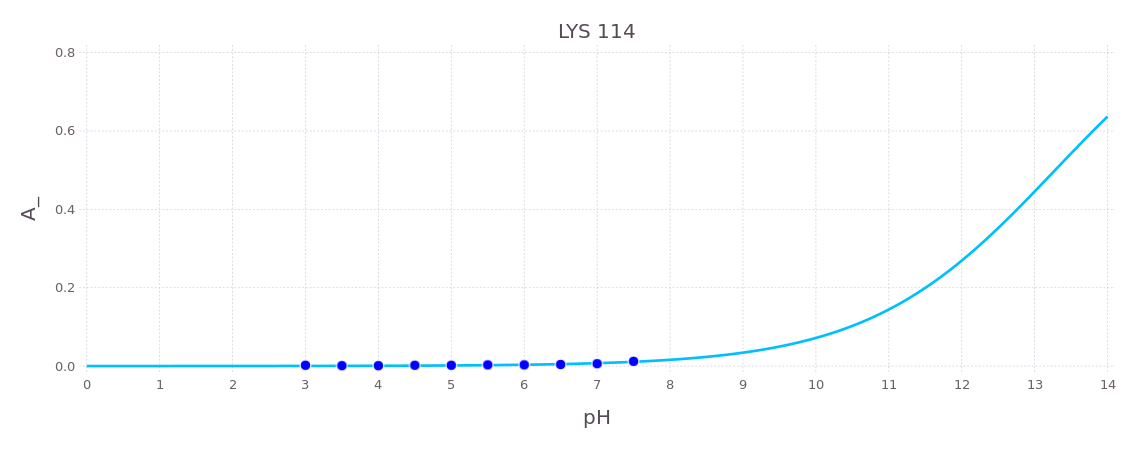

In [83]:
i = 35
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

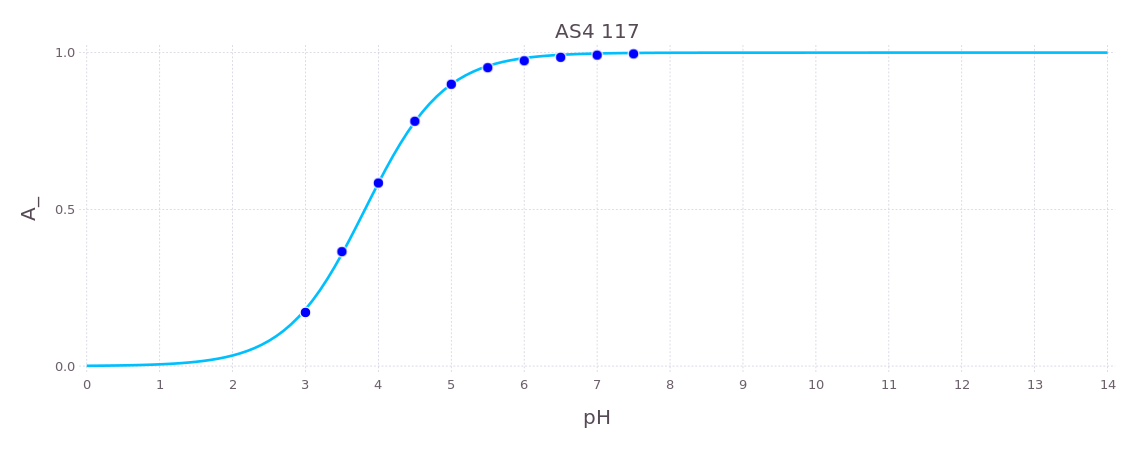

In [84]:
i = 36
lyr_pka_dots = layer(DataFrame(pH = ph_range ./ 10, A_ = deprotonated_fraction[i, :]),
    y = "A_", x = "pH", Geom.point, Theme(default_color = "blue",  point_size = 4pt))
lyr_titrable_curves = layer(DataFrame(A_ = titrable_curves[i](x), pH = x),
    x = "pH", y = "A_", Geom.line, Theme(default_color = "deepskyblue", line_width = 2pt))

plot(lyr_pka_dots, lyr_titrable_curves,    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))